## In this notebook we'll look at MDS, Landmark MDS, and their spectral distributions.


We try MDS-based dimensionality determination because distances between points are available. Algorithms that are based on distances only don't work well in high dimensions.

Later in this notebook, we look at the spectra for random matrices $\frac{1}{n}A A^T$. It turns out this spectra is known to converge as the number of rows of $A$ goes to infinity with a constant ratio to the columns:

https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

We consider the possibility of detecting IID data in a given dimension. We show that for IID data (e.g. Gaussian, uniform), the spectra obtained from MDS follows the MP law. However, using LMDS gives a different distribution. Another shortcoming is that the MP law is only followed when the dimensionality and number of sample points is large enough.

An MLE analysis of dimensionality has been looked at here:

http://www.jmlr.org/papers/volume9/hoyle08a/hoyle08a.pdf

One option is to match the MP distribution to the noise profile, see http://www.omicsonline.org/information-or-noise-that-is-the-question-2157-7420.1000e107.pdf

In [50]:
## numerical librarires
import numpy as np
from numpy import linalg as la
from numpy.random import normal
import random

from scipy.integrate import quad
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigh
from scipy.interpolate import interp1d

import cmath

## graphing
%matplotlib inline
import matplotlib.pyplot as plt
import copy

In [51]:
import sys
sys.path.append("/Users/gil/Documents/repos/cpp/vp_trees_cpp/vp_trees_cpp")
import vp_tree

In [52]:
num = 300
dim = 2
data = np.reshape([normal(0,1) for _ in range(dim*num)],(num,dim))

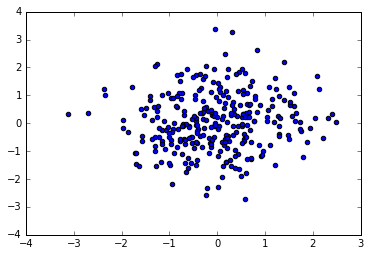

In [53]:
plt.scatter(*data.T)

In [54]:
def dist(x,y):
    return la.norm(x-y)

In [55]:
def find_separated_k_points(data,dist,k):
    if k > len(data) or k < 1:
        raise ValueError("must have 1 <= k <= n")
    points = [data[0]] ## can use seed instead
    distance_to_points = {tuple(p):np.inf for p in data}
    while len(points) < k:
        distance_to_last_point = map(lambda z: dist(z,points[-1]),data)
        distance_to_points.update({tuple(p):d for p,d in zip(data,distance_to_last_point) if d < distance_to_points[tuple(p)]})
        farthest_point = max(distance_to_points, key=distance_to_points.get)
        points.append(farthest_point)
    return np.asarray(points)

In [56]:
far_points = find_separated_k_points(data,dist,20)

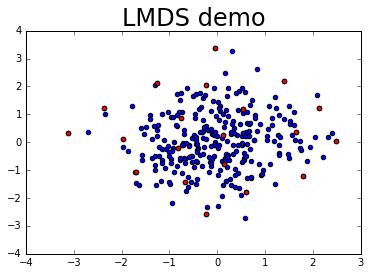

In [57]:
plt.scatter(*data.T)
plt.scatter(*far_points.T,c = 'r')
plt.title("LMDS demo",fontsize = 24)

##  Multidimensional scaling (MDS)

In [58]:
def MDS(points,dist,k = 2,solver = 'eigsh'):
    '''
    eigsh solves for the largest $k$ eigenvalues/eigenvectors. eigh solves for all. 
    Both assume symmteric matrices.
    '''
    if solver != 'eigsh' and solver != 'eigh':
        raise ValueError("unknown solver")
    
    data_size = len(points)
    
    Dis_squared = np.zeros((data_size,data_size))
    
    for i in range(data_size):
        for j in range(data_size):
            Dis_squared[i,j] = dist(points[i],points[j])**2
    
    Dis_squared_row_average = Dis_squared.sum(axis = 0) / data_size
    Dis_squared_row_and_col_average = Dis_squared_row_average.sum() / data_size

    B_matrix = np.zeros((data_size,data_size))
    for i in range(data_size):
        for j in range(data_size):
            B_matrix[i,j] = -0.5 * ( Dis_squared[i,j] - Dis_squared_row_average[i] - Dis_squared_row_average[j] + Dis_squared_row_and_col_average )

    if solver == 'eigsh':
        return eigsh(B_matrix,k=k)
    elif solver == 'eigh':
        return eigh(B_matrix)
    else:
        return None

In [59]:
## sample MDS.

MDS(far_points,dist,k=4)[0]

array([ -1.15461631e-14,   9.45254752e-15,   4.36481520e+01,
         4.45667264e+01])

In [60]:
## sample MDS with alternative eigensolver.

MDS(far_points,dist,solver='eigh')[0]

array([ -1.40308614e-14,  -5.69777028e-15,  -5.21075580e-15,
        -4.48102236e-15,  -3.22749226e-15,  -1.81897382e-15,
        -1.59473139e-15,  -8.40766474e-16,  -1.20784802e-16,
         1.81668052e-16,   3.47411337e-16,   1.78515275e-15,
         2.84372631e-15,   3.19010853e-15,   4.44241150e-15,
         5.18415051e-15,   8.62837146e-15,   1.04078241e-14,
         4.36481520e+01,   4.45667264e+01])

## Exploration of Marchenko–Pastur distribution in MDS on random points. Case when $dim == num$.

In [61]:
## metric to use between data points represented by lists.
def euclidean_dist(x,y):
    return la.norm(np.asarray(x) - np.asarray(y))

In [62]:
## http://stats.stackexchange.com/questions/87032/eigenvalues-of-correlation-matrices-exhibit-exponential-decay

## For when number of points == number of dimensions

def mu(x):
    return np.sqrt(4.*x - x**2) / (2.*np.pi*x)

def M(x):
    return quad(mu,0.,x)[0]

In [63]:
dim = 100
num = 100
eps = 1e-10

xs = np.linspace(eps,4.,dim)
ys = np.asarray(map(M,xs))

data1 = np.reshape([normal(0,1) for _ in range(dim*num)],(num,dim)).tolist()
data2 = np.reshape([random.uniform(-1,1) for _ in range(dim*num)],(num,dim)).tolist()

eig1 = MDS(data1,euclidean_dist,solver='eigh')[0]
eig1 /= sum(eig1)
eig2 = MDS(data2,euclidean_dist,solver='eigh')[0]
eig2 /= sum(eig2)

In [64]:
ys = np.asarray(map(M,xs))
xs[0] = 0.
ys[0] = 0.

## rescale from [0,1] to [1,50]
ys *= dim-1 
ys += 1

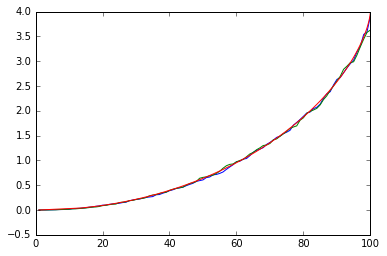

In [65]:
eigen_indices = range(1,dim+1)

plt.plot(eigen_indices,eig1*(dim))
plt.plot(eigen_indices,eig2*(dim))

plt.plot(ys,xs)

## Exploration of Marchenko–Pastur distribution in MDS on random points. Case when $num \ge dim$.

## https://galton.uchicago.edu/~lalley/Courses/386/Wigner.pdf
## https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

In [66]:
## eig1 and eig2 are respectively the MDS spectra of Gaussian noise and uniform noise.

dim = 100
num = 200

data1 = np.reshape([normal(0,1) for _ in range(dim*num)],(num,dim)).tolist()
data2 = np.reshape([random.uniform(-1,1) for _ in range(dim*num)],(num,dim)).tolist()

eig1 = MDS(data1,euclidean_dist,solver='eigh')[0]
eig1 /= sum(eig1)
eig2 = MDS(data2,euclidean_dist,solver='eigh')[0]
eig2 /= sum(eig2)

In [67]:
## eig3 will be the spectra of well-separated points as used by LMDS
oversample_factor = 100 ## to get the LMDS distribution, we oversample Gaussian noise and then find well separated points

data3 = np.reshape([normal(0,1) for _ in range(oversample_factor*dim*num)],(oversample_factor*num,dim)).tolist()
data3 = find_separated_k_points(data3,euclidean_dist,num)

eig3 = MDS(data3,euclidean_dist,solver='eigh')[0]
eig3 /= sum(eig3)

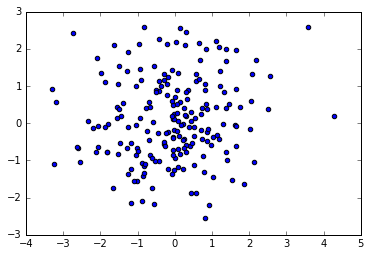

In [68]:
plt.scatter(*data3.T[:2])

In [69]:
## for when num >= dim

def mu(x):
    return np.sqrt((b-x)*(x-a))/(2.*np.pi*x*y)

def M(x):
    return quad(mu,a,x)[0]

In [70]:
y = float(dim)/num
a = (1. - np.sqrt(y))**2
b = (1. + np.sqrt(y))**2
eps = 1e-10

In [71]:
samples = 500 ## for interpolation of inverse of $M$ function

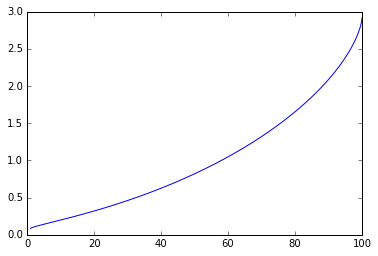

In [72]:
xs = np.linspace(eps+a,b,samples)
ys = np.asarray(map(M,xs))
xs[0] = a
ys[0] = 0.

## rescale from [0,1] to [1,50]
ys *= dim-1 
ys += 1 

plt.plot(ys,xs)

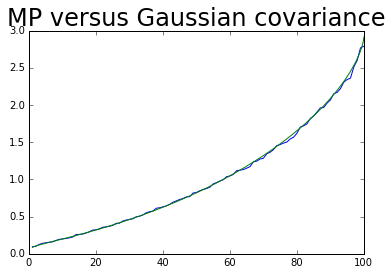

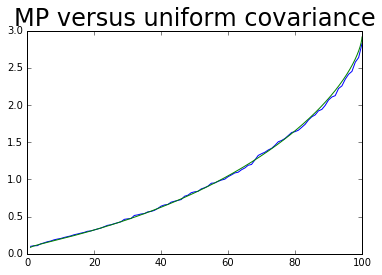

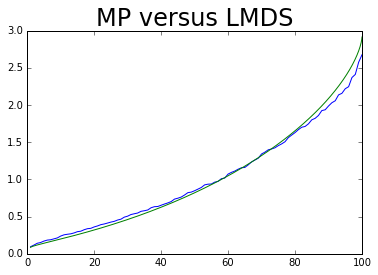

In [73]:
eigen_indices = range(1,min(dim,num)+1)

plt.plot(eigen_indices,eig1[-dim:]*(dim))
plt.plot(ys,xs)
plt.title("MP versus Gaussian covariance",fontsize=24)
plt.show()

plt.plot(eigen_indices,eig2[-dim:]*(dim))
plt.plot(ys,xs)
plt.title("MP versus uniform covariance",fontsize=24)
plt.show()

plt.plot(eigen_indices,eig3[-dim:]*(dim))
plt.plot(ys,xs)
plt.title("MP versus LMDS",fontsize=24)
plt.show()



Note: The first two distributions above appear to match the theoretical asymptotic distirbution. However, the last one does not. This is a consequence of the squared distances not being independent.

## Interpolating the inverse function of $M$. Doing this we can get an estimate for the spectral distribution as a function of eigenvalue number.

In [74]:
samples = 500 ## for interpolation of inverse of $M$ function

In [75]:
inter_func = interp1d(ys,xs)

In [76]:
eigen_indices = range(1,dim+1)

In [77]:
eigen_indices[-1] = ys[-1]

In [78]:
xs_interpolated = inter_func(eigen_indices)

In [79]:
xs_interpolated /= sum(xs_interpolated)

In [80]:
eig1_trunc = eig1[-dim:]
eig1_trunc /= sum(eig1_trunc)

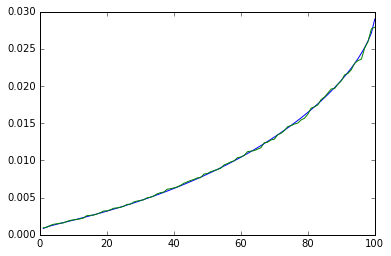

In [81]:
plt.plot(eigen_indices,xs_interpolated)
plt.plot(eigen_indices,eig1_trunc)

## Entropic divergence from  Marchenko–Pastur distribution

In [82]:
def KL_div(P,Q):
    '''
    KL divergence from Q to P
    '''
    return sum([p*np.log(p/q) if p >= 0 else 0. for p,q in zip(P,Q)])

In [83]:
def eig_trunc(eig,dim):
    '''
    Truncate the spectra to the appropriate dimension to compare with the Marchenko-Pastur distribution.
    '''
    eig_trunc = copy.copy(eig[-dim:])
    eig_trunc /= sum(eig_trunc)
    return eig_trunc

In [84]:
KL_div(eig_trunc(eig1,dim),xs_interpolated)

0.00013981645758085392

In [85]:
KL_div(eig_trunc(eig2,dim),xs_interpolated)

0.00018432087934015622

In [86]:
KL_div(eig_trunc(eig3,dim),xs_interpolated)

0.001646023658759085

## Next, let's compute the KL divergence for each distribution from the Marchenko-Pastur eigenspectra as a function of dimension.

In [87]:
def MP_spectra(dim,num,eps = 1e-10,samples=200):
    '''
    eps and samples are values used in the interpolation of the spectra from the PDF
    '''
    def mu(x):
        return np.sqrt((b-x)*(x-a))/(2.*np.pi*x*y)

    def M(x):
        return quad(mu,a,x)[0]

    y = float(dim)/num
    a = (1. - np.sqrt(y))**2
    b = (1. + np.sqrt(y))**2

    xs = np.linspace(eps+a,b,samples)
    ys = np.asarray(map(M,xs))

    ## rescale from [0,1] to [1,50]
    ys *= dim - 1. 
    ys += 1.

    ## indices where to interpolate the values of the Marchenko-Pastur spectra
    eigen_indices = range(1,dim+1)


    ## make sure all values are in the proper range, these should match but might vary due to numerical error
    eigen_indices[0] = ys[0]
    eigen_indices[-1] = ys[-1]

    ## interpolate to find values at eigenvalues
    inter_func = interp1d(ys,xs)
    xs_interpolated = inter_func(eigen_indices)

    ## normalize spectra
    xs_interpolated /= sum(xs_interpolated)

    return xs_interpolated

In [88]:
def get_spectra(eig,dim,num,eps = 1e-10,samples=200, plot_spectra = True):
    '''
    Correct for $dim <= num$. Different equation must be used for other case, 
    
    https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
    '''
    
    if num < dim:
        raise ValueError("Please use dim <= num in this function.")
    
    xs_interpolated = MP_spectra(dim,num,eps = 1e-10,samples=200)
    
    eig_val_trunc = eig_trunc(eig,dim)
    
    if plot_spectra:
        plt.plot(xs_interpolated)
        plt.plot(eig_val_trunc)
        plt.show()
    
    return KL_div(eig_val_trunc,xs_interpolated)

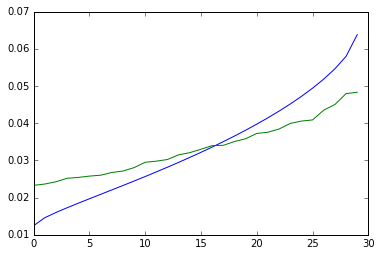

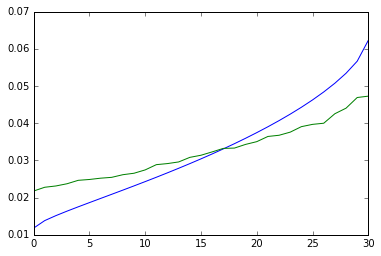

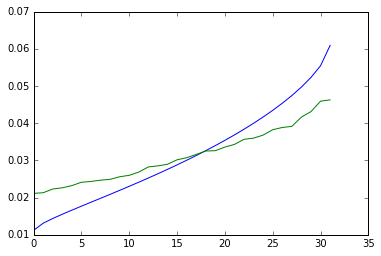

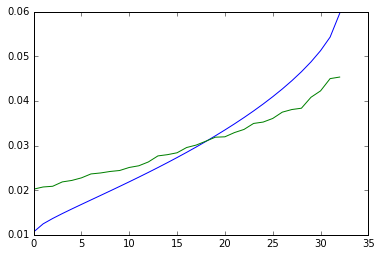

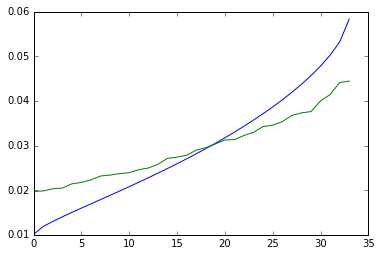

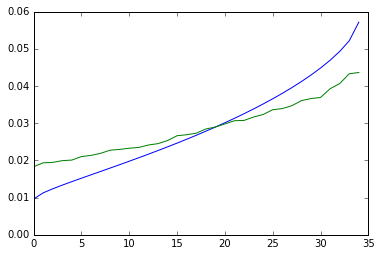

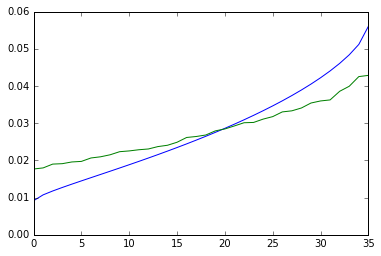

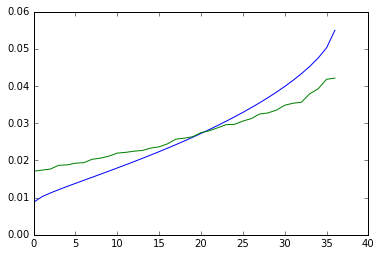

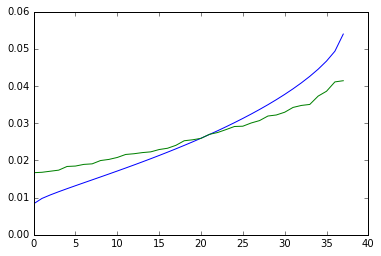

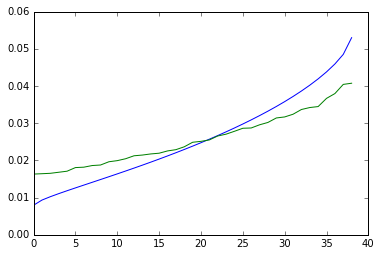

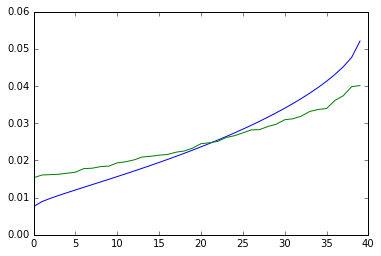

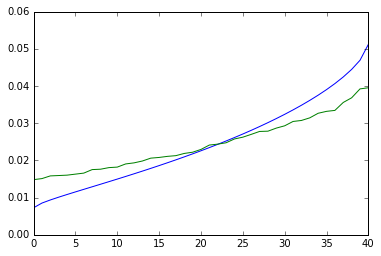

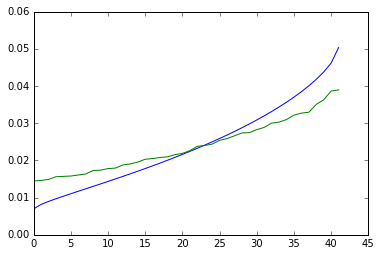

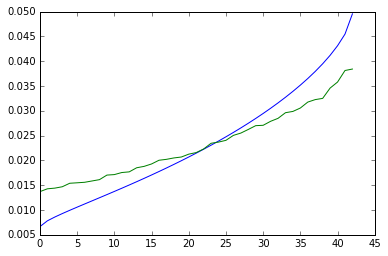

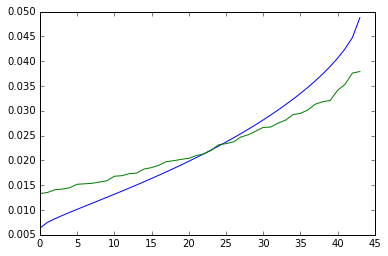

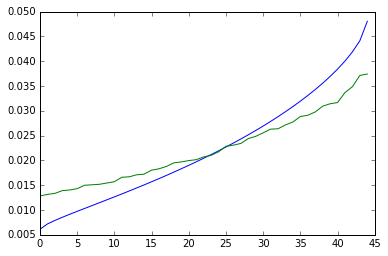

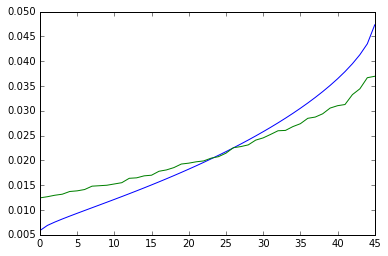

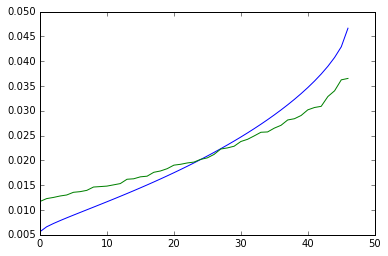

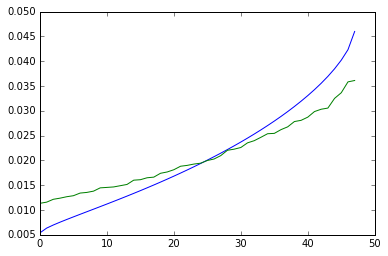

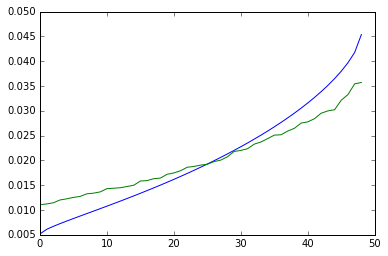

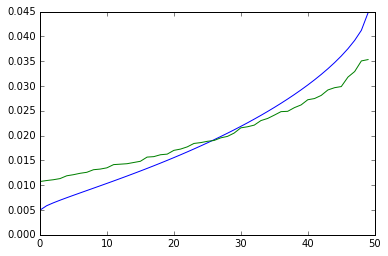

In [89]:
dims = range(30,51)
KLs = []
for dim in dims:
    KLs.append(get_spectra(eig1,dim,num))

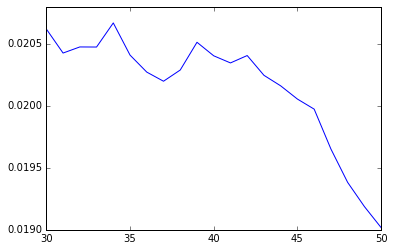

In [90]:
plt.plot(dims,KLs)

## Next let's organize things together in functions

In [91]:
def get_gaussian_eigs(dim,num):
    '''
    Empirical spectra from MDS algorithm on random gaussian data.
    '''

    data1 = np.reshape([normal(0,1) for _ in range(dim*num)],(num,dim)).tolist()
    eig1 = MDS(data1,euclidean_dist,solver='eigh')[0]
    eig1 /= sum(eig1)
    return eig1

In [92]:
dim = 5
num = 30
eig1 = get_gaussian_eigs(dim,num) ## get random eigenvalue distribution for num points in dim dimensions.

dims = range(max(2,dim-10),min(dim+10,num+1))
KLs = []
for d in dims:
    KLs.append(get_spectra(eig1,d,num,plot_spectra=False))

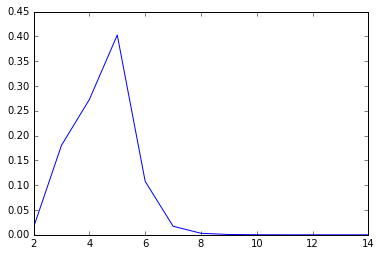

In [93]:
##  scores for different dimensions

KL_probs = map(lambda z: np.exp(-z*num),KLs) ## a wild estimate
KL_probs /= sum(KL_probs)
plt.plot(dims,KL_probs)

## What happens if we take many samples of the eigenvalues and average?

In [94]:
def compare_many_samples(
    dim = 20,
    num = 30,
    num_samples = 100):

    eig_lst = np.asarray([get_gaussian_eigs(dim,num)[-dim:] for _ in range(num_samples)])
    MP_eigs = MP_spectra(dim,num)

    eig_ave = np.average(eig_lst,axis=0)
    eig_std = np.std(eig_lst,axis=0) / np.sqrt(num_samples-1) ## sample standard deviation

    plt.plot(eig_ave)
    plt.plot(eig_ave + eig_std, c = 'r')
    plt.plot(eig_ave - eig_std, c = 'r')

    plt.plot(MP_eigs,c = 'g')

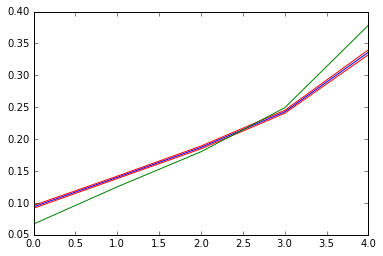

In [95]:
compare_many_samples(dim = 5)

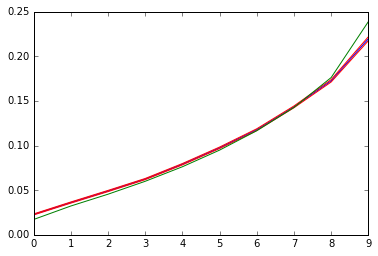

In [96]:
compare_many_samples(dim = 10)

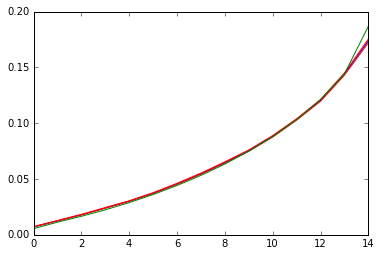

In [97]:
compare_many_samples(dim = 15)

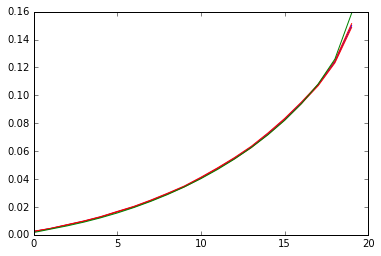

In [98]:
compare_many_samples(dim = 20)

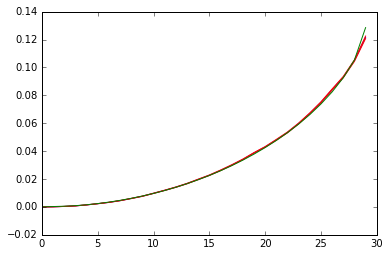

In [99]:
compare_many_samples(dim = 30)

### As the dimension increases, the spectra approaches the theoretical function. For small dimensions it is not so great.

## How often is our estimate correct?

In [100]:
def estiamte_dim(dim = 5,num = 30):
    eig1 = get_gaussian_eigs(dim,num) ## get random eigenvalue distribution for num points in dim dimensions.

    dims = range(max(2,dim-10),min(dim+10,num+1))
    KLs = []
    for d in dims:
        KLs.append(get_spectra(eig1,d,num,plot_spectra=False))
    return max(2,dim-10) + np.argmin(KLs)

In [101]:
outs = {}

In [102]:
outs[5,30] = []
for _ in range(100):
    outs[5,30].append(estiamte_dim(5,30))

(array([  1.,   0.,   0.,   2.,   0.,   0.,   9.,   0.,   0.,  88.]),
 array([ 2. ,  2.3,  2.6,  2.9,  3.2,  3.5,  3.8,  4.1,  4.4,  4.7,  5. ]),
 <a list of 10 Patch objects>)

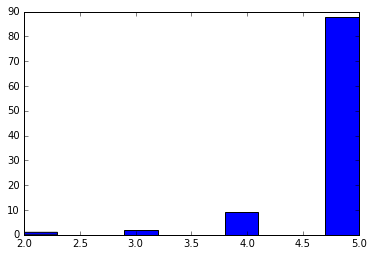

In [103]:
plt.hist(outs[5,30])

## Notes

There is a general tendency to underestimate the dimension because it is easier to rule out a higher dimension (the eigenvalues become zero far enough in the spectrum). 

The number of points sampled doesn't improve the results much when made large. There is an improvement when $num$ is somewhat larger than $dim$, but the improvement plateaus around $num \approx 2 dim$ or so (very approximately).

The algorithm also seems to work better for larger dimensions because (i) it is closer to Marchenko-Pastur distribution and (ii) there are more points to sample from.

# Exploration of dimensionality using LMDS

## Many Samples for LMDS

In [104]:
def make_LMDS_sample(dim,num,oversample_factor = 100):
    '''
    oversample_factor is used toto get the LMDS distribution, we oversample Gaussian noise and then find well separated points
    '''

    data3 = np.reshape([normal(0,1) for _ in range(oversample_factor*dim*num)],(oversample_factor*num,dim)).tolist()
    data3 = find_separated_k_points(data3,euclidean_dist,num)

    ## eig3 will be the spectra of well-separated points as used by LMDS
    eig3 = MDS(data3,euclidean_dist,solver='eigh')[0]
    eig3 /= sum(eig3)
    return eig3

In [105]:
def compare_many_samples_LMDS(
    dim = 20,
    num = 30,
    oversample_factor = 100,
    num_samples = 100):

    eig_lst = np.asarray([make_LMDS_sample(dim,num)[-dim:] for _ in range(num_samples)])
    MP_eigs = MP_spectra(dim,num)

    eig_ave = np.average(eig_lst,axis=0)
    eig_std = np.std(eig_lst,axis=0) / np.sqrt(num_samples-1) ## sample standard deviation

    plt.plot(eig_ave)
    plt.plot(eig_ave + eig_std, c = 'r')
    plt.plot(eig_ave - eig_std, c = 'r')

    plt.plot(MP_eigs,c = 'g')

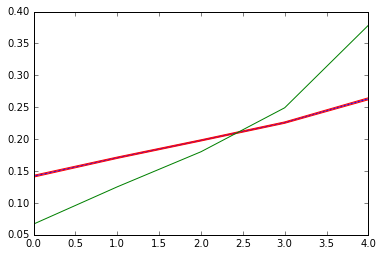

In [106]:
compare_many_samples_LMDS(5)

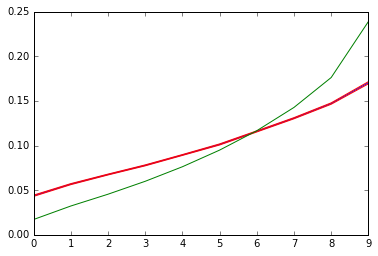

In [107]:
compare_many_samples_LMDS(10)

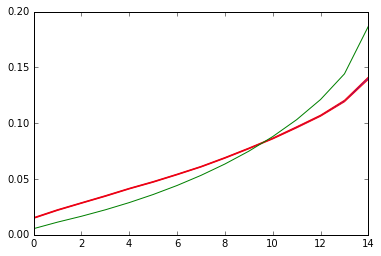

In [108]:
compare_many_samples_LMDS(15)

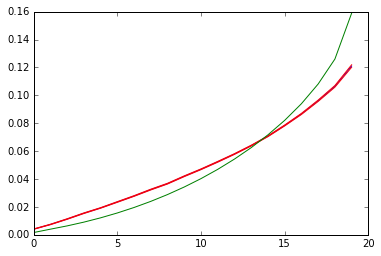

In [109]:
compare_many_samples_LMDS(20)

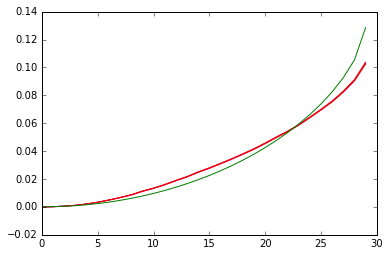

In [110]:
compare_many_samples_LMDS(30)

### Above, we see that the LMDS eigenvalues converge to some distribution for each instance of dim,num, number of samples. However, we see this distribution is different than when the various data are drawn from an IID distribution. In practice, if we wish to deduce dimensionality from LMDS, we much know the true distribution of the eigenvalues given the parameters.

## Trying to use the entropy measure to predict dimension of LMDS

In [111]:
dim = 5
num = 30

In [112]:
eig3 = make_LMDS_sample(dim,num,oversample_factor = 100)

In [113]:
dims = range(max(2,dim-10),min(dim+10,num+1))
KLs = []
for d in dims:
    KLs.append(get_spectra(eig3,d,num,plot_spectra=False))

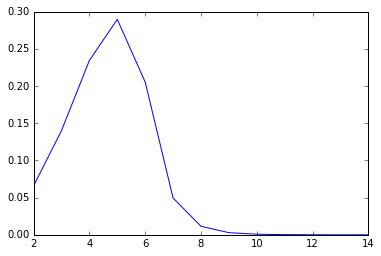

In [114]:
# plt.plot(dims,KLs)
KL_probs = map(lambda z: np.exp(-z*num),KLs) ## a wild estimate
KL_probs /= sum(KL_probs)
plt.plot(dims,KL_probs)

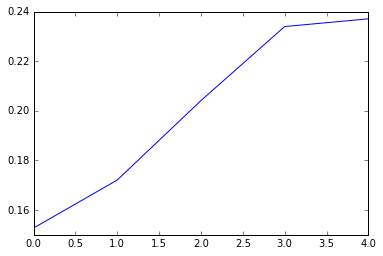

In [115]:
plt.plot(eig3[-dim:])

## How often is our estimate correct using LMDS?

In [116]:
def estiamte_dim_LMDS(dim = 5,num = 30, oversample_factor = 100):
    
    data3 = np.reshape([normal(0,1) for _ in range(oversample_factor*dim*num)],(oversample_factor*num,dim)).tolist()
    data3 = find_separated_k_points(data3,euclidean_dist,num)

    eig3 = MDS(data3,euclidean_dist,solver='eigh')[0]
    eig3 /= sum(eig3)

    dims = range(max(2,dim-10),min(dim+10,num+1))
    KLs = []
    for d in dims:
        KLs.append(get_spectra(eig3,d,num,plot_spectra=False))
    return max(2,dim-10) + np.argmin(KLs)

In [117]:
outs_LMDS = {}

In [118]:
outs_LMDS[5,30] = []
for _ in range(100):
    outs_LMDS[5,30].append(estiamte_dim_LMDS(5,30))

(array([  2.,   0.,   0.,   3.,   0.,   0.,  12.,   0.,   0.,  83.]),
 array([ 2. ,  2.3,  2.6,  2.9,  3.2,  3.5,  3.8,  4.1,  4.4,  4.7,  5. ]),
 <a list of 10 Patch objects>)

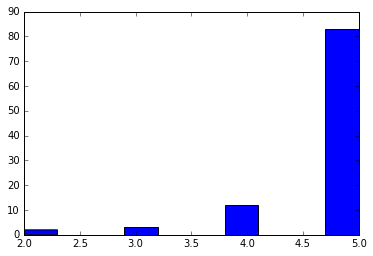

In [119]:
plt.hist(outs_LMDS[5,30])

# Let's consider data drawn from a signal + noise 

### Suppose we don't know what the signal looks like, but the noise profile is Gaussian. Then the lower eigenvalues correspond to a noise-only subspace. We 

In [120]:
def make_signal_and_noise(
    num = 300,
    dim = 20,
    noise_strength = 1.,
    signal_strengths = [np.sqrt(10.),np.sqrt(20.),np.sqrt(30.)],
    ):
    data = np.reshape([normal(0,noise_strength) for _ in range(dim*num)],(num,dim))
    for i in range(num):
        for j,strength in enumerate(signal_strengths):
            data[i,j] += [normal(0,strength)]
    return data

In [121]:
num = 100
dim = 50
num_signals = 10
signal_strengths = [2. for i in range(num_signals)]

In [122]:
data = make_signal_and_noise(num=num,dim=dim,signal_strengths=signal_strengths)

In [123]:
eigs = MDS(data,euclidean_dist,k = dim)

In [124]:
eig_vals =eigs[0][::-1]

In [125]:
eig_vals/=sum(eig_vals)

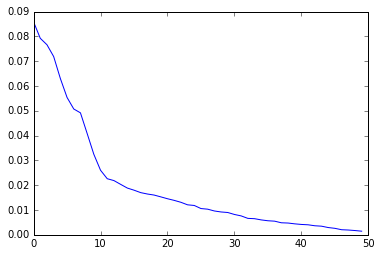

In [126]:
plt.plot(eig_vals)

# Fitting the MP distribution to noise

## Given a hypothesis dimension $k$, let's try to fit the $MP$ distribution to the noise terms (which would correspond to smallest $dim-k$ eigenvalues).

We reverse the eigenvalues below to match the notation in some papers.

In [127]:
def get_comaprison_spectra(eig_vals,k,num,dim):
    noise_dim = dim-k

    MP_eigs = MP_spectra(noise_dim,num,eps = 1e-10,samples=200)[::-1]
    MP_eigs /= sum(MP_eigs)
    noise_hypothesis_eigs = copy.copy(eig_vals[-noise_dim:])
    noise_hypothesis_eigs /= sum(noise_hypothesis_eigs)
    return MP_eigs,noise_hypothesis_eigs

0.00615740574889


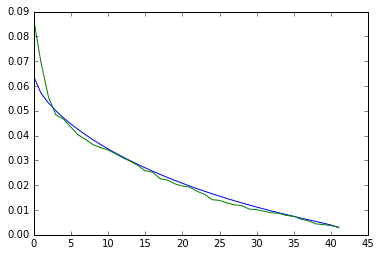

In [128]:
MP_eigs,noise_hypothesis_eigs = get_comaprison_spectra(eig_vals,8,num,dim)
plt.plot(MP_eigs)
plt.plot(noise_hypothesis_eigs)
print KL_div(MP_eigs,noise_hypothesis_eigs)

0.000645472911786


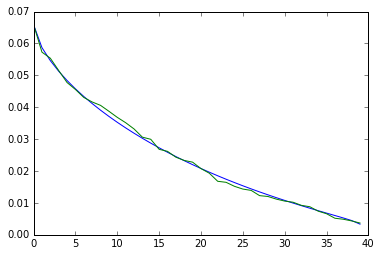

In [129]:
MP_eigs,noise_hypothesis_eigs = get_comaprison_spectra(eig_vals,10,num,dim)
plt.plot(MP_eigs)
plt.plot(noise_hypothesis_eigs)
print KL_div(MP_eigs,noise_hypothesis_eigs)

0.000930933707673


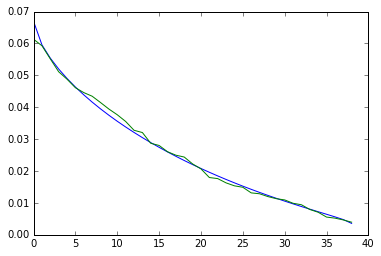

In [130]:
MP_eigs,noise_hypothesis_eigs = get_comaprison_spectra(eig_vals,11,num,dim)
plt.plot(MP_eigs)
plt.plot(noise_hypothesis_eigs)
print KL_div(MP_eigs,noise_hypothesis_eigs)

## The above method may not work well since several low noise dimensions may fit the same distribution well enough.

# from Minka's paper: T.P. Minka. Automatic choice of dimensionality for PCA.

In [131]:
# from scipy.special import gamma
from scipy.special import gammaln

In [132]:
k = 20

In [133]:
v = v_hat(num,dim,k,eig_vals)

In [134]:
L = Lambdas(eig_vals,v,dim,k)

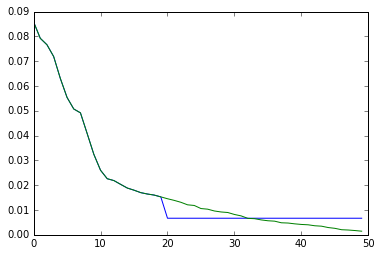

In [135]:
plt.plot(L)
plt.plot(eig_vals)

In [138]:
def v_hat(num,dim,k,eig_vals):
    '''
    MLE of the noise level $v$.
    '''
    return num*sum(eig_vals[k:])/ ((num+1.) *(dim-k) - 2.)

def area_inv(dim,k):
    '''
    Returns the log of the inverse area:
    
    $\frac{1}{Area(V_k(\mathbb{R}^dim))}
    =
    2^{-k} \prod_{i=0}^{k-1} \Gamma((dim-i)/2) \pi^{-(dim-i)/2}$
    '''
    val = -k*np.log(2.)
    for i in range(k):
        val += gammaln((dim-i)/2.) -(dim-i)/2. * np.log(np.pi)
    return val

def Lambdas(eig_vals,v,dim,k):
    '''
    The estimates $\Lambda_i \approx \lambda_i$ if $i +1 <= k$, or $\Lambda_i = v$ if $i+1 > k$.
    '''
    return np.asarray([v if i+1>k  else eig_vals[i] for i in range(dim)])

def A_z(eig_vals,v,dim,k,num):
    '''
    Returns the log of $|A_Z|$, which is given by
    
    $|A_Z| = \prod_{i=0}^{k-1} \prod_{j=1+1}^{dim-1} 
    \left( ({\Lambda_j}^{-1} - {\Lambda_i}^{-1}) (\lambda_i - \lambda_j) * num \right) $
    '''
    L = Lambdas(eig_vals,v,dim,k)
    val = 0.
    for i in range(k):
        for j in range(i+1,dim):
            val += np.log( (1./L[j]-1./L[i])*(eig_vals[i] - eig_vals[j])) + np.log( float(num) )
    return val

def p(num,dim,k,eig_vals):
    '''
    Log likelihood of the probability of dimension $k$ given the other values. The probability is given by
    
    $p = \frac{1}{Area(V_k(\mathbb{R}^dim))} (\prod_{j=0}^{k-1} \lambda_j)^{-num/2} 
        v^{-num(dim-k)/2} (2 \pi)^{(m+k)/2} |A_Z|^{-1/2} * num^{-k/2} $
    
    Here $m = dim*k - k*(k+1.)/2.$.
    '''
    v = v_hat(num,dim,k,eig_vals)
    A = A_z(eig_vals,v,dim,k,num)
    ar = area_inv(dim,k)
    m = dim*k - k*(k+1.)/2.
    return (ar - num/2.*sum(np.log(eig_vals[:k])) -
            num*(dim-k)/2.*np.log(v)+(m+k)/2.*np.log(2.*np.pi) 
            - A/2.-k/2.*np.log(num) )

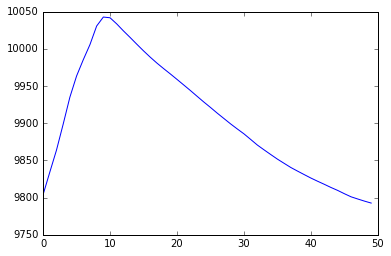

In [139]:
ps = []
for l in range(dim):
    ps.append(p(num,dim,l,eig_vals))
plt.plot(ps)

## Check with an implementation from scikit-learn:

In [140]:
def _assess_dimension_(spectrum, rank, n_samples, n_features):
    """Compute the likelihood of a rank ``rank`` dataset
    The dataset is assumed to be embedded in gaussian noise of shape(n,
    dimf) having spectrum ``spectrum``.
    Parameters
    ----------
    spectrum: array of shape (n)
        Data spectrum.
    rank: int
        Tested rank value.
    n_samples: int
        Number of samples.
    n_features: int
        Number of features.
    Returns
    -------
    ll: float,
        The log-likelihood
    Notes
    -----
    This implements the method of `Thomas P. Minka:
    Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604`
    """
    if rank > len(spectrum):
        raise ValueError("The tested rank cannot exceed the rank of the"
                         " dataset")

    pu = -rank * np.log(2.)
    for i in range(rank):
        pu += (gammaln((n_features - i) / 2.) -
               np.log(np.pi) * (n_features - i) / 2.)

    pl = np.sum(np.log(spectrum[:rank]))
    pl = -pl * n_samples / 2.

    if rank == n_features:
        pv = 0
        v = 1
    else:
        v = np.sum(spectrum[rank:]) / (n_features - rank)
        pv = -np.log(v) * n_samples * (n_features - rank) / 2.

    m = n_features * rank - rank * (rank + 1.) / 2.
    pp = np.log(2. * np.pi) * (m + rank + 1.) / 2.

    pa = 0.
    spectrum_ = spectrum.copy()
    spectrum_[rank:n_features] = v
    for i in range(rank):
        for j in range(i + 1, len(spectrum)):
            pa += np.log((spectrum[i] - spectrum[j]) *
                      (1. / spectrum_[j] - 1. / spectrum_[i])) + np.log(n_samples)

    ll = pu + pl + pv + pp - pa / 2. - rank * np.log(n_samples) / 2.

    return ll

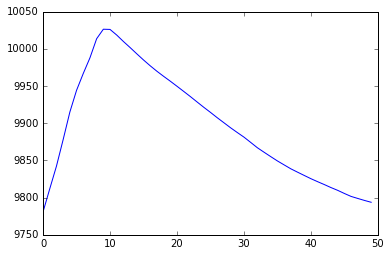

In [141]:
ps = []
for l in range(dim):
    ps.append(_assess_dimension_(eig_vals,l,num,dim))
plt.plot(ps)



# Began to implement Hoyle's paper. It is useful when the number of samples is smaller than the dimensionality.

## Automatic PCA Dimension Selection for High Dimensional Data and Small Sample Sizes

In [142]:
def estimate_noise_and_signal(num,dim,k,lambd):
    ell = copy.copy(lambd)
    
    v_hat = sum(lambd) / dim
    
    for it in range(100):
        a = (1. + 1./float(num)) / v_hat
        for i in range(len(eigs)):
            b = - lambd[i] / v_hat + float(dim)/num - 1.-(3.+float(k))/float(num)
            c = lambd[i]
            ell[i] = (-b + (cmath.sqrt(b**2 - 4.*a*c))) /( 2. * a)
        v_hat =  (float(num)/((num+1.)*(d-k))) * (sum(lambd[-num:]) - sum([(1.+1./num)*eig for eig in ell[-k:]]))
    return ell

In [143]:
eig_estimate = estimate_noise_and_signal(num,dim,30,eig_vals)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


In [144]:
eig_estimate /= sum(eig_estimate)

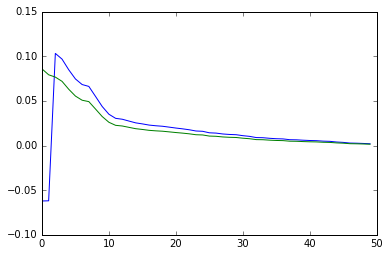

In [145]:
plt.plot(eig_estimate)
plt.plot(eig_vals)